# 02 — Neural Data Statistics

Overview of raw spike data properties: per-recording summary statistics, example rasters, and angular-position tuning curve quality.

In [16]:
from remapping.dataset import (
    MiceDataset, Animals, GROUP_ORDER, SESSION_ORDER,
    SESSION_TYPE_MAP, EXPERIMENT_TYPE_ORDER, EXPERIMENT_TYPE_COLORS,
)
from remapping.plotting import PlotStyle, get_figures_path
from remapping.processing import smooth_tuning_curves_circularly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

mice = MiceDataset()
style = PlotStyle()
palette = mice.get_group_palette()

fig_path = get_figures_path("0.data_overview", "02_neural_data_statistics")

## Parameters

In [17]:
# Processing parameters (matching the standard pipeline)
ONLY_MOVING = True
BINS_COMPRESS = 3        # temporal binning factor (30.9 Hz → ~10.3 Hz)
BINS_SMOOTHING = 3       # Gaussian σ for firing rate smoothing
BINS_PHI = 360           # angular bins for tuning curves
TC_SMOOTH_KERNEL = 20    # circular smoothing kernel for tuning curves

# Example subject for raster plot
EXAMPLE_SUBJECT = Animals.M62

# Timing
FS_ORIGINAL = 30.9                         # original sampling rate (Hz)
FS_BINNED = FS_ORIGINAL / BINS_COMPRESS    # ~10.3 Hz after binning
BIN_DURATION_MS = 1000.0 / FS_BINNED      # ~97 ms per bin

## 1. Per-recording spike statistics

Summary table with one row per recording (subject × FOV × session × run). For each recording we report: number of neurons, duration, mean spike rate across neurons, fraction of active neurons, and peak spike amplitude.

In [18]:
recording_stats = []

for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    group = f"{info['genotype']}_{info['age']}"
    for fov in mice.get_available_fovs(subject):
        for session in mice.get_available_sessions(subject, fov):
            for run in mice.get_available_runs(subject, fov, session):
                spikes_b, phi_b, time_b, (cell_ids, _) = mice.load_spikes(
                    subject, fov, session, run,
                    only_moving=ONLY_MOVING, bins_compress=BINS_COMPRESS,
                )
                n_neurons = spikes_b.shape[1]
                n_bins = spikes_b.shape[0]
                duration_s = n_bins / FS_BINNED

                # Mean spike rate per neuron (Hz): mean spikes per bin × bins per second
                mean_rate_hz = spikes_b.mean(axis=0) * FS_BINNED  # (N,)
                # Fraction of time bins where each neuron is active
                frac_active = (spikes_b > 0).mean(axis=0)  # (N,)

                recording_stats.append({
                    "Subject": subject.value,
                    "Group": group,
                    "FOV": fov,
                    "Session": session,
                    "Run": run,
                    "N neurons": n_neurons,
                    "Duration (s)": round(duration_s, 1),
                    "Mean rate (Hz)": round(mean_rate_hz.mean(), 3),
                    "Std rate (Hz)": round(mean_rate_hz.std(), 3),
                    "Mean frac active": round(frac_active.mean(), 3),
                    "Max spike amp": round(spikes_b.max(), 2),
                })

df_rec = pd.DataFrame(recording_stats)
print(f"Total recordings: {len(df_rec)}")
df_rec

Total recordings: 321


,Subject,Group,FOV,Session,Run,N neurons,Duration (s),Mean rate (Hz),Std rate (Hz),Mean frac active,Max spike amp
0,m62,WT_old,2,fam1fam2,fam1,292,458.2,0.530,0.427,0.016,40.87
1,m62,WT_old,2,fam1fam2,fam2,292,429.5,0.431,0.418,0.014,26.47
2,m62,WT_old,2,fam1nov,fam1,247,777.1,0.439,0.352,0.013,31.49
3,m62,WT_old,2,fam1nov,nov,247,543.2,0.276,0.374,0.008,34.43
4,m62,WT_old,2,fam1fam1rev,fam1,232,682.1,0.365,0.401,0.011,30.97
...,...,...,...,...,...,...,...,...,...,...,...
316,m132,5xFAD_young,2,fam1novfam1,nov,167,910.1,0.177,0.098,0.008,11.09
317,m132,5xFAD_young,2,fam1novfam1,fam1r2,167,495.0,0.218,0.123,0.008,13.58
318,m132,5xFAD_young,2,fam1fam1revfam1,fam1,188,554.5,0.244,0.146,0.008,14.13
319,m132,5xFAD_young,2,fam1fam1revfam1,fam1rev,188,648.8,0.242,0.117,0.009,12.74


### Spike rate distributions by group

Distribution of mean spike rate and spike-rate variability (std across neurons) for each recording, split by genotype × age group. Each point is one recording.

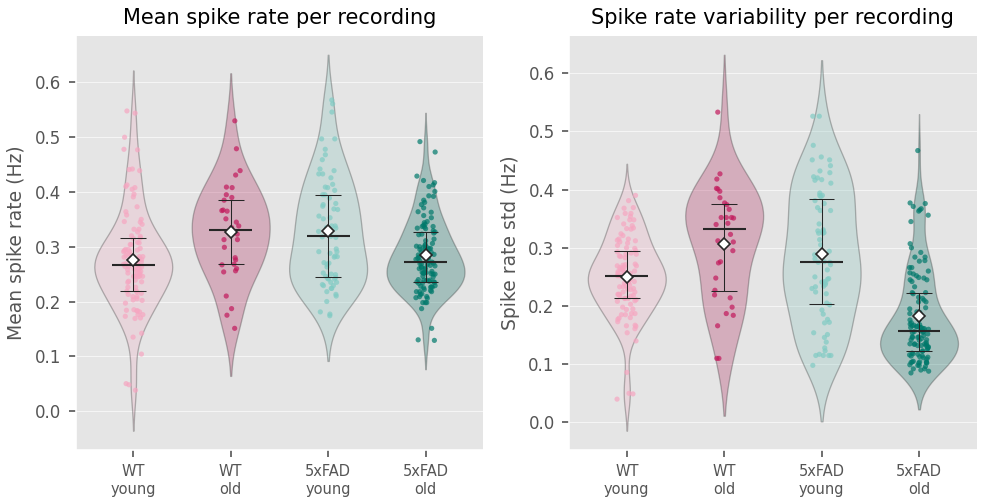

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(PlotStyle.FULL_WIDTH, 3.5))

for ax, col, label in zip(
    axes,
    ["Mean rate (Hz)", "Std rate (Hz)"],
    ["Mean spike rate (Hz)", "Spike rate std (Hz)"],
):
    sns.violinplot(
        data=df_rec, x="Group", y=col, hue="Group",
        order=GROUP_ORDER, palette=palette,
        inner=None, alpha=0.3, ax=ax, legend=False,
    )
    sns.stripplot(
        data=df_rec, x="Group", y=col, hue="Group",
        order=GROUP_ORDER, palette=palette,
        size=2.5, alpha=0.7, jitter=True, ax=ax, legend=False,
    )
    # Overlay mean, Q25, median, Q75 for each group
    for xi, group in enumerate(GROUP_ORDER):
        vals = df_rec.loc[df_rec["Group"] == group, col]
        q25, median, q75 = np.percentile(vals, [25, 50, 75])
        mean = vals.mean()
        hw = 0.22  # half-width of the stat lines
        # IQR bar
        ax.vlines(xi, q25, q75, color="0.15", linewidth=0.5, zorder=4)
        # Q25 / Q75 caps
        ax.hlines([q25, q75], xi - hw * 0.6, xi + hw * 0.6, color="0.15", linewidth=0.5, zorder=4)
        # Median line
        ax.hlines(median, xi - hw, xi + hw, color="0.15", linewidth=1, zorder=5)
        # Mean diamond
        ax.plot(xi, mean, marker="D", color="white", markeredgecolor="0.15",
                markersize=4, zorder=6, markeredgewidth=0.8)

    ax.set_xlabel("")
    ax.set_ylabel(label)
    ax.set_xticks(range(len(GROUP_ORDER)))
    ax.set_xticklabels([g.replace("_", "\n") for g in GROUP_ORDER], fontsize=7)

axes[0].set_title("Mean spike rate per recording")
axes[1].set_title("Spike rate variability per recording")
plt.tight_layout()
fig.savefig(fig_path / "spike_rate_distributions.pdf")
plt.show()

## 2. Example raster plot

Raw spike raster for an example subject, showing 20 neurons over the first 60 seconds as a heatmap. Pixel intensity encodes spike amplitude.

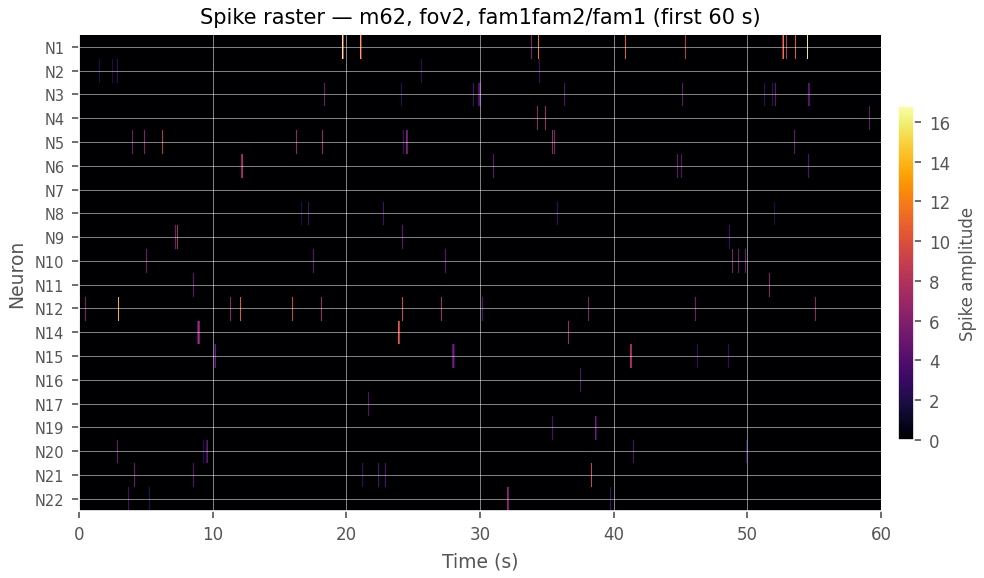

In [20]:
# Pick first available recording for the example subject
ex_fov = mice.get_available_fovs(EXAMPLE_SUBJECT)[0]
ex_sess = mice.get_available_sessions(EXAMPLE_SUBJECT, ex_fov)[0]
ex_run = mice.get_available_runs(EXAMPLE_SUBJECT, ex_fov, ex_sess)[0]

df_raw = mice.load_data(EXAMPLE_SUBJECT, ex_fov, ex_sess, ex_run)
cell_cols = [c for c in df_raw.columns if c.isdigit()]
time_s = df_raw["glob_time"].values - df_raw["glob_time"].values[0]

# Select first 60 seconds and 20 neurons
t_max = 60  # seconds
mask_t = time_s <= t_max
n_show = min(20, len(cell_cols))
sel_cells = cell_cols[:n_show]

spikes_raw = df_raw.loc[mask_t, sel_cells].values.T  # (n_show, T)
time_show = time_s[mask_t]

fig, ax = plt.subplots(figsize=(PlotStyle.FULL_WIDTH, 4))
im = ax.imshow(
    spikes_raw, aspect="auto", interpolation="none",
    cmap="inferno", vmin=0,
    extent=[time_show[0], time_show[-1], n_show - 0.5, -0.5],
)
ax.grid(
    True, which="major",
    color="white",
    linewidth=0.3,   # thinner than default
    alpha=0.8
)
ax.set_yticks(range(n_show))
ax.set_yticklabels([f"N{c}" for c in sel_cells], fontsize=7)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Neuron")
ax.set_title(f"Spike raster — {EXAMPLE_SUBJECT.value}, fov{ex_fov}, {ex_sess}/{ex_run} (first {t_max} s)")

cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
cbar.set_label("Spike amplitude", fontsize=8)

plt.tight_layout()
fig.savefig(fig_path / "example_raster.pdf")
plt.show()

## 3. Tuning curve selectivity (angular-position tuning)

For each neuron, compute a selectivity index from its angular-position tuning curve: the ratio of peak to mean activity. High values indicate strong spatial tuning. We compare distributions across genotype × age groups.

In [21]:
# Compute selectivity index per neuron from angular-position tuning curves
selectivity_rows = []

for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    group = f"{info['genotype']}_{info['age']}"
    for fov in mice.get_available_fovs(subject):
        for session in mice.get_available_sessions(subject, fov):
            for run in mice.get_available_runs(subject, fov, session):
                fr, phi_b, _, (cell_ids, _), tc, phi_bins = (
                    mice.load_firing_rates(
                        subject, fov, session, run,
                        only_moving=ONLY_MOVING,
                        bins_compress=BINS_COMPRESS,
                        bins_smoothing=BINS_SMOOTHING,
                        bins_phi=BINS_PHI,
                    )
                )
                tc_smooth = smooth_tuning_curves_circularly(tc, TC_SMOOTH_KERNEL)

                for j in range(tc_smooth.shape[1]):
                    curve = tc_smooth[:, j]
                    mean_val = np.nanmean(curve)
                    peak_val = np.nanmax(curve)
                    selectivity = peak_val / mean_val if mean_val > 0 else 0.0
                    selectivity_rows.append({
                        "Subject": subject.value,
                        "Group": group,
                        "Session": session,
                        "Run": run,
                        "Neuron": cell_ids[j],
                        "selectivity": selectivity,
                        "peak": peak_val,
                        "mean_tc": mean_val,
                    })

df_sel = pd.DataFrame(selectivity_rows)
print(f"Neurons with tuning curves: {len(df_sel):,}")
df_sel.describe()

Neurons with tuning curves: 63,924


,selectivity,peak,mean_tc
count,63924.000000,63924.000000,63924.000000
mean,2.797288,0.125458,0.053999
std,1.874227,0.099692,0.043611
min,0.000000,0.000000,0.000000
25%,1.857528,0.060592,0.023552
50%,2.313243,0.096548,0.044254
75%,3.097950,0.160559,0.072107
max,18.000000,0.929354,0.462667


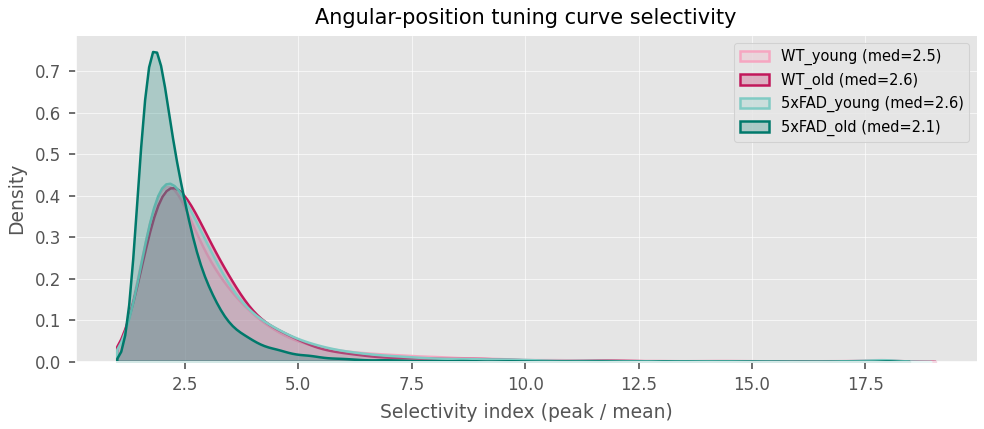

In [22]:
fig, ax = plt.subplots(figsize=(PlotStyle.FULL_WIDTH, 3))

for group in GROUP_ORDER:
    subset = df_sel.loc[df_sel["Group"] == group, "selectivity"]
    sns.kdeplot(
        subset, ax=ax, color=palette[group], fill=True, alpha=0.25,
        linewidth=1.2, clip=(1, None), label=f"{group} (med={subset.median():.1f})",
    )

ax.set_xlabel("Selectivity index (peak / mean)")
ax.set_ylabel("Density")
ax.set_title("Angular-position tuning curve selectivity")
ax.legend(fontsize=7)
plt.tight_layout()
fig.savefig(fig_path / "tuning_selectivity.pdf")
plt.show()

## 4. Firing rate traces

The firing rate is obtained by convolving binned spikes with a Gaussian kernel (σ = `BINS_SMOOTHING` bins ≈ 0.29 s) and applying a square-root transform. Below we show example traces for a few neurons from `EXAMPLE_SUBJECT`.

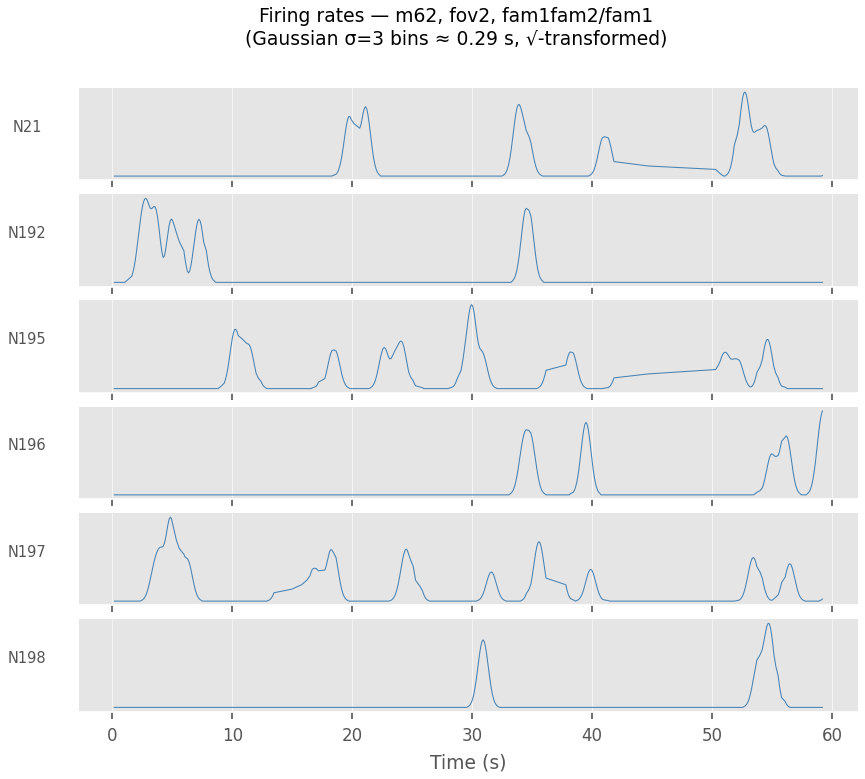

In [23]:
# Load firing rates for the example subject
ex_fov = mice.get_available_fovs(EXAMPLE_SUBJECT)[0]
ex_sess = mice.get_available_sessions(EXAMPLE_SUBJECT, ex_fov)[0]
ex_run = mice.get_available_runs(EXAMPLE_SUBJECT, ex_fov, ex_sess)[0]

fr_ex, phi_ex, time_ex, (cells_ex, _), _, _ = mice.load_firing_rates(
    EXAMPLE_SUBJECT, ex_fov, ex_sess, ex_run,
    only_moving=ONLY_MOVING, bins_compress=BINS_COMPRESS,
    bins_smoothing=BINS_SMOOTHING, bins_phi=BINS_PHI,
)

# Show first 6 neurons, first 60 seconds
n_traces = min(6, fr_ex.shape[1])
t_mask = time_ex <= 60
time_plot = time_ex[t_mask]

fig, axes = plt.subplots(n_traces, 1, figsize=(PlotStyle.FULL_WIDTH, 0.9 * n_traces),
                          sharex=True, gridspec_kw={"hspace": 0.15})
for i in range(n_traces):
    axes[i].plot(time_plot, fr_ex[t_mask, i], linewidth=0.5, color="steelblue")
    axes[i].set_ylabel(f"N{cells_ex[i]}", fontsize=7, rotation=0, labelpad=25)
    axes[i].set_yticks([])
    axes[i].spines["left"].set_visible(False)

axes[-1].set_xlabel("Time (s)")
fig.suptitle(
    f"Firing rates — {EXAMPLE_SUBJECT.value}, fov{ex_fov}, {ex_sess}/{ex_run}\n"
    f"(Gaussian σ={BINS_SMOOTHING} bins ≈ {BINS_SMOOTHING / FS_BINNED:.2f} s, √-transformed)",
    fontsize=9,
)
fig.subplots_adjust(top=0.88)
fig.savefig(fig_path / "firing_rate_traces.pdf")
plt.show()

## 5. Effect of smoothing kernel on population correlations

How does the Gaussian kernel width (σ) change the pairwise correlation structure of the population? Wider kernels smooth out fast fluctuations, increasing correlations between neurons that share slow dynamics. We compute the median pairwise Pearson r for one example recording across different σ values.

In [24]:
# Sweep σ values for one recording per group
sigma_values = [0, 1, 2, 3, 5, 8, 12, 20]  # in bins (~97 ms each)
sigma_time_ms = [s / FS_BINNED * 1000 for s in sigma_values]

corr_results = []

for group in GROUP_ORDER:
    genotype, age = group.split("_")
    s = mice.get_subjects_by_group(genotype, age)[0]
    fov = mice.get_available_fovs(s)[0]
    sess = mice.get_available_sessions(s, fov)[0]
    run_ = mice.get_available_runs(s, fov, sess)[0]

    # Load binned spikes once
    spikes_b, _, _, _ = mice.load_spikes(
        s, fov, sess, run_,
        only_moving=ONLY_MOVING, bins_compress=BINS_COMPRESS,
    )

    for sigma in sigma_values:
        if sigma == 0:
            fr = np.sqrt(spikes_b.astype(float))
        else:
            fr = np.sqrt(gaussian_filter1d(spikes_b.astype(float), sigma=sigma, axis=0))

        # Drop zero-variance neurons to avoid NaN correlations
        variances = fr.var(axis=0)
        fr = fr[:, variances > 0]

        C = np.corrcoef(fr.T)
        iu = np.triu_indices(C.shape[0], k=1)
        vals = C[iu]

        corr_results.append({
            "Group": group,
            "sigma_bins": sigma,
            "sigma_ms": sigma / FS_BINNED * 1000,
            "median_corr": np.median(vals),
            "mean_corr": np.mean(vals),
            "q25": np.percentile(vals, 25),
            "q75": np.percentile(vals, 75),
        })

df_sigma = pd.DataFrame(corr_results)
df_sigma

,Group,sigma_bins,sigma_ms,median_corr,mean_corr,q25,q75
0,WT_young,0,0.000000,-0.003195,0.002557,-0.009472,0.010454
1,WT_young,1,97.087379,-0.003009,0.007374,-0.024834,0.031139
2,WT_young,2,194.174757,-0.001377,0.010635,-0.039589,0.051426
3,WT_young,3,291.262136,0.000127,0.012827,-0.050126,0.066499
4,WT_young,5,485.436893,0.003139,0.015256,-0.063779,0.085449
5,WT_young,8,776.699029,0.008395,0.016956,-0.073653,0.101233
6,WT_young,12,1165.048544,0.012000,0.018630,-0.080965,0.111399
7,WT_young,20,1941.747573,0.014743,0.020323,-0.084972,0.118846
8,WT_old,0,0.000000,-0.002920,0.004270,-0.010498,0.012758
9,WT_old,1,97.087379,-0.001147,0.011898,-0.024340,0.036008


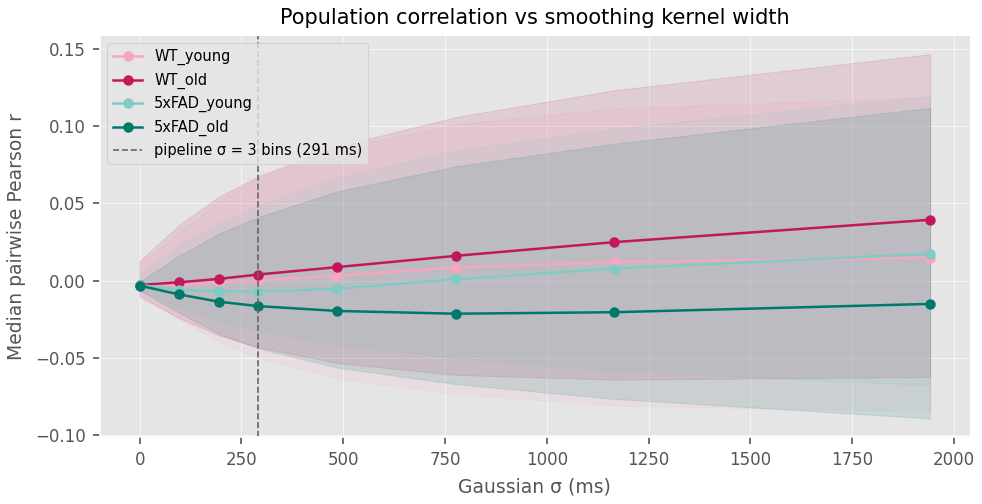

In [25]:
fig, ax = plt.subplots(figsize=(PlotStyle.FULL_WIDTH, 3.5))

for group in GROUP_ORDER:
    sub = df_sigma[df_sigma["Group"] == group]
    ax.plot(sub["sigma_ms"], sub["median_corr"], "o-", color=palette[group],
            label=group, lw=1.2, markersize=4)
    ax.fill_between(sub["sigma_ms"], sub["q25"], sub["q75"],
                     color=palette[group], alpha=0.12)

# Mark the standard pipeline σ
std_sigma_ms = BINS_SMOOTHING / FS_BINNED * 1000
ax.axvline(std_sigma_ms, color="0.4", ls="--", lw=0.8,
           label=f"pipeline σ = {BINS_SMOOTHING} bins ({std_sigma_ms:.0f} ms)")

ax.set_xlabel("Gaussian σ (ms)")
ax.set_ylabel("Median pairwise Pearson r")
ax.set_title("Population correlation vs smoothing kernel width")
ax.legend(fontsize=7)
plt.tight_layout()
fig.savefig(fig_path / "smoothing_kernel_correlations.pdf")
plt.show()

## 6. Pairwise correlation distributions at different kernel widths

Full distribution of pairwise Pearson correlations for three representative kernel widths (σ = 0 / raw spikes, σ = 3 / standard pipeline, σ = 12 / wide), shown for one example recording. This visualises how smoothing reshapes the population correlation structure.

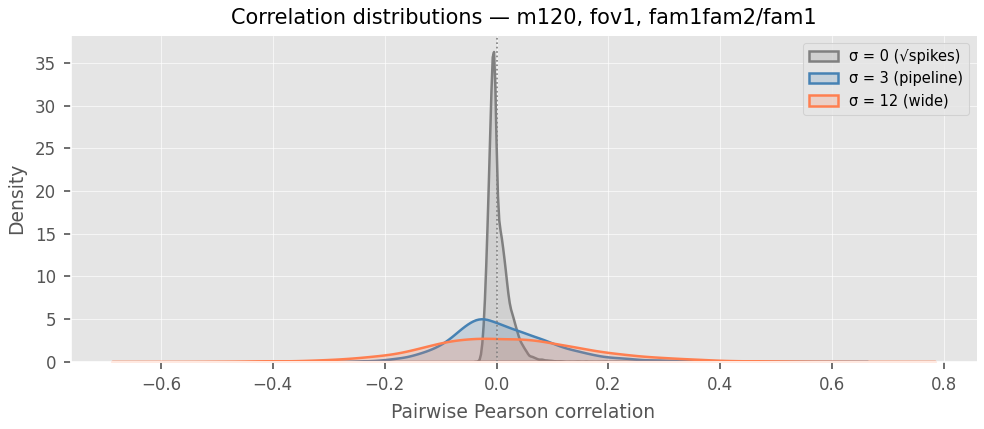

In [26]:
# Pick one example recording (first group, first subject)
ex_group = GROUP_ORDER[0]
g, a = ex_group.split("_")
ex_s = mice.get_subjects_by_group(g, a)[0]
ex_f = mice.get_available_fovs(ex_s)[0]
ex_se = mice.get_available_sessions(ex_s, ex_f)[0]
ex_r = mice.get_available_runs(ex_s, ex_f, ex_se)[0]

spikes_ex, _, _, _ = mice.load_spikes(
    ex_s, ex_f, ex_se, ex_r,
    only_moving=ONLY_MOVING, bins_compress=BINS_COMPRESS,
)

highlight_sigmas = [0, BINS_SMOOTHING, 12]
sigma_labels = {0: "σ = 0 (√spikes)", BINS_SMOOTHING: f"σ = {BINS_SMOOTHING} (pipeline)", 12: "σ = 12 (wide)"}
sigma_colors = {0: "0.5", BINS_SMOOTHING: "steelblue", 12: "coral"}

fig, ax = plt.subplots(figsize=(PlotStyle.FULL_WIDTH, 3))

for sigma in highlight_sigmas:
    if sigma == 0:
        fr_tmp = np.sqrt(spikes_ex.astype(float))
    else:
        fr_tmp = np.sqrt(gaussian_filter1d(spikes_ex.astype(float), sigma=sigma, axis=0))

    # Drop zero-variance neurons to avoid NaN correlations
    variances = fr_tmp.var(axis=0)
    fr_tmp = fr_tmp[:, variances > 0]

    C = np.corrcoef(fr_tmp.T)
    iu = np.triu_indices(C.shape[0], k=1)
    vals = C[iu]
    sns.kdeplot(vals, ax=ax, color=sigma_colors[sigma], fill=True, alpha=0.2,
                linewidth=1.2, label=sigma_labels[sigma])

ax.axvline(0, color="0.5", ls=":", lw=0.8)
ax.set_xlabel("Pairwise Pearson correlation")
ax.set_ylabel("Density")
ax.set_title(f"Correlation distributions — {ex_s.value}, fov{ex_f}, {ex_se}/{ex_r}")
ax.legend(fontsize=7)
plt.tight_layout()
fig.savefig(fig_path / "correlation_distributions_kernels.pdf")
plt.show()